# Market Segmentation for a French (C2C) Fashion Store

Market segmentation for a french (C2C) fashion store using cluster analysis to achieve more effective customer marketing via personalization. Process is automated for using with subsequent data.  

The data source is 'data.world' portal https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store.  

The focus of the project is customers who are active users of the platform in selling field. To be consider as an active user, they should have at least one listed, sold, bought, liked or wishes product.  

As the some very valuable customers are not relevant to common pattern of behaviour the clustering has performed in two levels: prevalent type of customers (2 types) and special cases (4 types). Moreover, there are 3 clients with stand out features.  

Due to large number of location of customers and very different level of using the platform, countries that are location of less then 1% of total users are regarded as 'Other' in analysis.  


### Importing packages, loading the data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import cluster, tree, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

# Download the dataset
# Source https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store
fl = '2. Prepared Data/6M-0K-99K.users.dataset.public.csv'
data = pd.read_csv(fl)

# Preview data
data.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-7279641312655250028,user,Etats-Unis,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,us
1,-1456013578740053406,user,Allemagne,de,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,de
2,9006282053848196165,user,Suède,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,689,3205,106.83,8.9,se
3,-7154634866120535654,user,Turquie,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,tr
4,2858299215060733023,user,France,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,709,3205,106.83,8.9,fr


## 1. Data Preprocessing

### 1.1. Exploratory Data Analysis & Data Cleaning

In [2]:
# Get base information on the dataset
data.columns

Index(['identifierHash', 'type', 'country', 'language', 'socialNbFollowers',
       'socialNbFollows', 'socialProductsLiked', 'productsListed',
       'productsSold', 'productsPassRate', 'productsWished', 'productsBought',
       'gender', 'civilityGenderId', 'civilityTitle', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'seniorityAsMonths', 'seniorityAsYears', 'countryCode'],
      dtype='object')

In [3]:
# Drop columns with information that will not be used or is duplicated 
drop_columns = ['civilityGenderId', 'civilityTitle', 'seniorityAsMonths', 'seniorityAsYears','countryCode']
data.drop(columns=drop_columns, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  int64  
 1   type                 98913 non-null  object 
 2   country              98913 non-null  object 
 3   language             98913 non-null  object 
 4   socialNbFollowers    98913 non-null  int64  
 5   socialNbFollows      98913 non-null  int64  
 6   socialProductsLiked  98913 non-null  int64  
 7   productsListed       98913 non-null  int64  
 8   productsSold         98913 non-null  int64  
 9   productsPassRate     98913 non-null  float64
 10  productsWished       98913 non-null  int64  
 11  productsBought       98913 non-null  int64  
 12  gender               98913 non-null  object 
 13  hasAnyApp            98913 non-null  bool   
 14  hasAndroidApp        98913 non-null  bool   
 15  hasIosApp            98913 non-null 

In [4]:
# Get the dimensionality of the dataset
print(data.shape)

(98913, 19)


In [5]:
# Check that user identification numbers are unique
users = len(data['identifierHash'].unique().tolist())
print(f'Duplicated users: {users-data.shape[0]}')

# Chech type of users is 'user' 
user_types = (data['type']=='user').sum() - data.shape[0]

# Drop 'type' column if type of all users is 'user' 
if user_types==0:
    data.drop(columns='type', inplace=True)
    
# Drop rows if type of users is different from 'user'
# Then drop 'type' column
else:
    other_types = data['type']!='user'
    data.drop(data[other_types].index, inplace=True)
    data.drop(columns='type', inplace=True)

Duplicated users: 0


In [6]:
# Check duplicated rows
print(f'Duplicated rows : {data.duplicated().sum()}')
# Find missing values 
print(f'Missing values: {data.isnull().sum().sum()}')

Duplicated rows : 0
Missing values: 0


In [7]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numeric_cols = data.select_dtypes([np.int64,np.float64]).columns.tolist()
print (f'Numeric: {len(numeric_cols)} \n{numeric_cols}')

categorical_cols = data.select_dtypes([np.object]).columns.tolist()
print (f'Categorical: {len(categorical_cols)} \n{categorical_cols}')

booleans_cols = data.select_dtypes([np.bool]).columns.tolist()
print (f'Boolean: {len(booleans_cols)} \n{booleans_cols}')

Columns
Numeric: 11 
['identifierHash', 'socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniority']
Categorical: 3 
['country', 'language', 'gender']
Boolean: 4 
['hasAnyApp', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture']


In [8]:
# Filter data of active users, who sold, bought, wished or liked products

###################################### FILTER ################################################

# List of columns related to user activity in selling of products
products = ['socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought']
# Calculate sum across rows
data['productSum'] = data[products].sum(axis=1)

# Filter data of user who have any activity (sum > 0)
data = data[data['productSum'] > 0]

# Drop utility 'productSum' column
data.drop(columns='productSum', inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)

# Preview data
data.head()

,identifierHash,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority
0,-7877915015908472168,Royaume-Uni,en,3,8,4,0,0,0.0,0,0,F,False,False,False,True,591,3205
1,-8231936648814680895,Danemark,en,3,8,370,0,0,0.0,1,0,F,False,False,False,True,42,3205
2,5663923945758514393,Etats-Unis,en,3,8,1,0,0,0.0,0,0,F,False,False,False,True,32,3205
3,-3483039296670050121,Allemagne,de,3,8,27,0,0,0.0,0,0,M,True,False,True,True,669,3205
4,3451396970677435825,Suisse,en,3,8,0,0,0,0.0,9,0,F,True,True,False,True,463,3205


In [9]:
# Get the dimensionality of the dataset
print(data.shape)

(21639, 18)


In [10]:
# Get statistics for numeric columns
data.drop(columns='identifierHash').describe() 

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniority
count,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,4.557558,9.911271,20.207450,0.426498,0.555802,3.713078,7.142705,0.785896,384.445631,3063.934979
std,8.155680,112.960063,386.638353,4.367049,4.520774,17.874985,53.491932,4.937857,271.408591,168.278417
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2852.000000
25%,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,2857.000000
50%,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000,3196.000000
75%,4.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,680.000000,3201.000000
max,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,709.000000,3205.000000


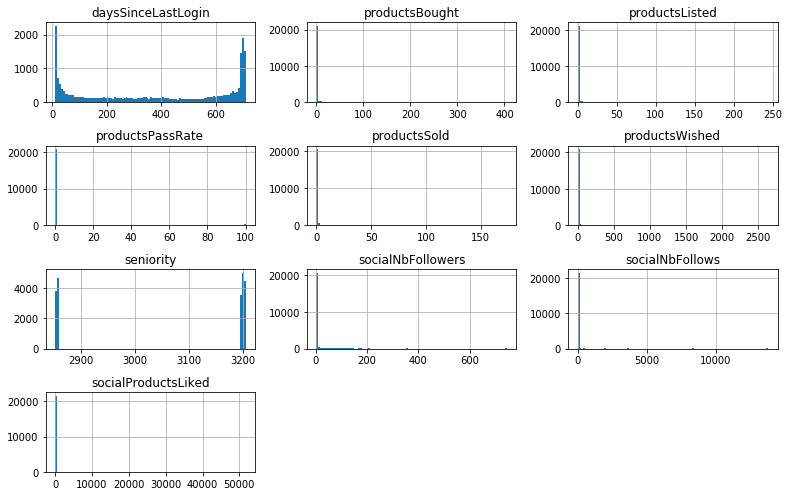

In [11]:
# Plot the distribution of numerical columns

# Create list of numerical columns for plots
# Copy the list of numerical columns
numeric_cols_plot = numeric_cols.copy()
# Remove the 'identifierHash' column
numeric_cols_plot.remove('identifierHash')
# Plot histograms
data[numeric_cols_plot].hist(figsize=(11,7), bins=100)
plt.tight_layout()

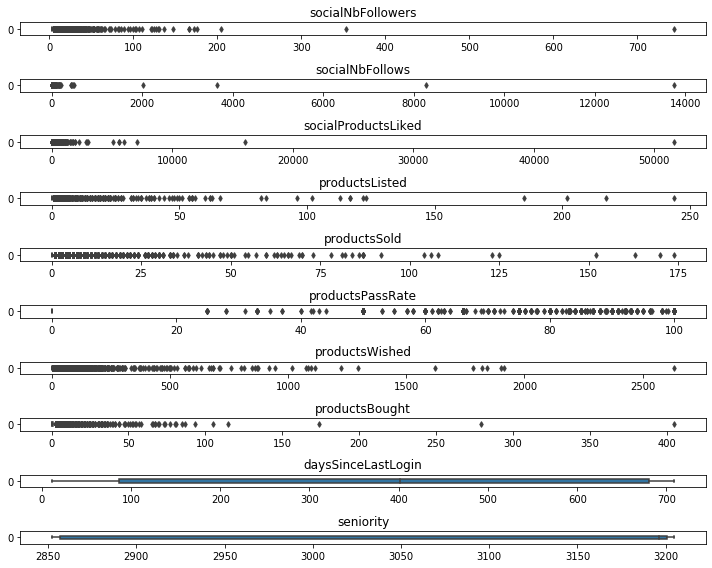

In [12]:
# Plot boxplots

fig, axes = plt.subplots(nrows=len(numeric_cols_plot),ncols=1,figsize=(10,8))
for index, column in enumerate(numeric_cols_plot):
    ax=sns.boxplot(data=data[column],orient='h', ax=axes[index], width=0.3, fliersize=4, color=color)
    ax.set_title(data[column].name)

plt.tight_layout()

In [13]:
# Generate pairplot
#sns.pairplot(data[numeric_cols].drop(columns=drop_num_cols))

Text(0.5, 1, 'Correlation Matrix')

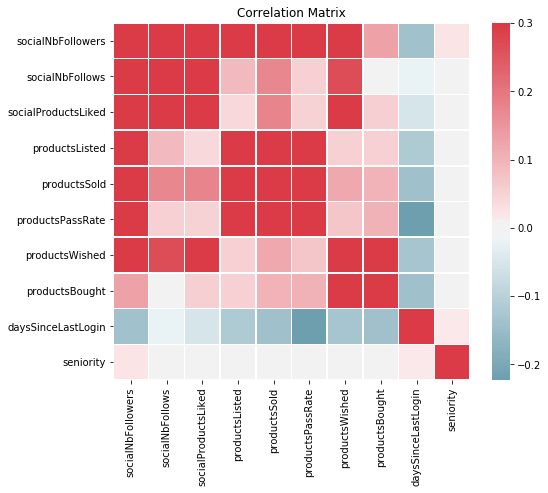

In [14]:
# Generate our corelation plot or heatmap
corr = data[numeric_cols_plot].corr()
# Generate heatmap
plt.figure(figsize = (8,8))
cmap = sns.diverging_palette(220,10,as_cmap = True)

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,cmap=cmap,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Correlation Matrix')

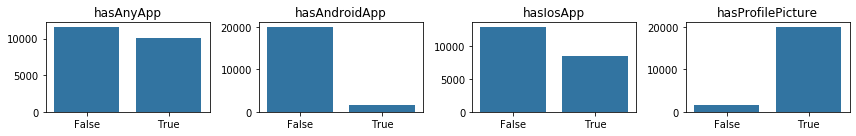

In [15]:
# Plot booleans data
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2))
for index, column in enumerate(booleans_cols):
    ax=sns.countplot(x=data[column],orient='h', ax=axes[index], color=color)
    ax.set_title(data[column].name)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()

In [16]:
# Plot categorical data
# Count number of countries
countries_number = len(data['country'].unique().tolist())
print(f'Countries: {countries_number}')

# Translate the list of countries into English 
data['country'] = data['country'].replace({
     'Royaume-Uni':'UK', 'Danemark':'Denmark','Etats-Unis':'US', 'Allemagne':'Germany', 
     'Suisse':'Swiss','Suède':'Sweden','Australie':'Australia','Italie':'Italy', 'Espagne':'Spain', 
     'Finlande':'Finland','Belgique':'Belgium','Pays-Bas':'Netherlands', 'Autriche':'Austria', 
    'Russie':'Russia', 'Bulgarie':'Bulgaria', 'Chine':'China', 'Irlande': 'Ireland', 'Roumanie':'Romania'})

# Group users by country
countries=pd.DataFrame(data['country'].value_counts()).sort_values(by='country',ascending=False)
countries.rename(columns={'country':'users'}, inplace=True)
# Calculate % of total users by country
countries['users_%_total'] = round(countries['users']/countries['users'].sum(),3)*100

# Number of users by country
users_20 = countries.head(20)
users_20

Countries: 127


,users,users_%_total
France,4972,23.0
US,3927,18.1
UK,2555,11.8
Italy,1993,9.2
Germany,1835,8.5
Spain,1048,4.8
Australia,631,2.9
Denmark,614,2.8
Sweden,497,2.3
Netherlands,482,2.2


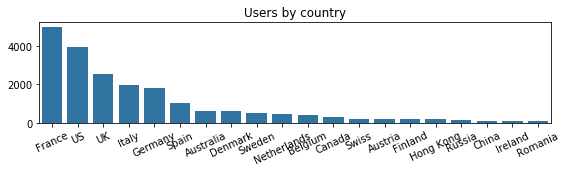

In [17]:
# Plot categorical data
fig, ax1 = plt.subplots(figsize=(8,2.5))

sns.barplot(x=users_20.index, y=users_20['users'], color=color, ax=ax1)

ax1.set_title('Users by country')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.xaxis.set_tick_params(rotation=25)

plt.tight_layout()

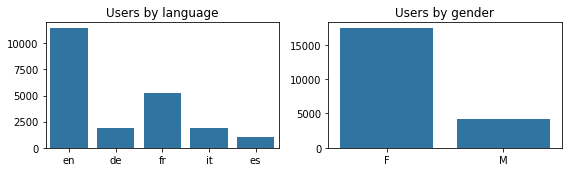

In [18]:
# Plot categorical data
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(8,2.5))

sns.countplot(x=data['language'],orient='h', color=color, ax=ax1)
sns.countplot(x=data['gender'],orient='h', color=color, ax=ax2)

ax1.set_title('Users by language')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2.set_title('Users by gender')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()

In [19]:
# Selling by country
selling_filter = (data['productsListed']==0) & (data['productsSold']==0)
selling_data = data[~selling_filter]
selling_data_group=selling_data.groupby('country')[['productsSold', 'productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).reset_index()
selling_data_group['%sold']=round(selling_data_group[('productsSold', 'sum')]/selling_data_group[('productsSold', 'sum')].sum(),3)*100
selling_data_group['%listed']=round(selling_data_group[('productsListed', 'sum')]/selling_data_group[('productsListed', 'sum')].sum(),3)*100
selling_top10=selling_data_group.nlargest(10,('productsSold', 'sum'))
# Start the index from 1
selling_top10.index=selling_top10.index+1
print('Products sold by top 10 countries')
selling_top10

Products sold by top 10 countries


,country,productsSold,productsListed,%sold,%listed
,,sum,sum,,
1,France,3014,2242,25.1,24.3
2,Italy,2820,2401,23.4,26.0
3,UK,1806,1025,15.0,11.1
4,Spain,990,667,8.2,7.2
5,US,967,962,8.0,10.4
6,Germany,536,349,4.5,3.8
7,Sweden,336,237,2.8,2.6
8,Netherlands,214,157,1.8,1.7
9,Monaco,190,27,1.6,0.3


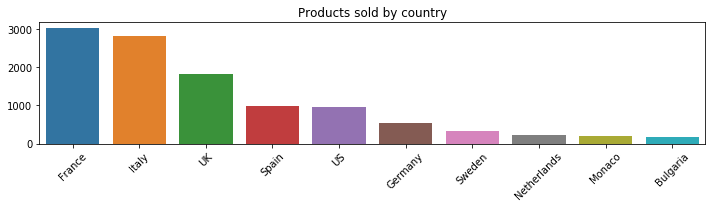

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=selling_top10['country'],y=selling_top10[('productsSold', 'sum')])
ax.set_title('Products sold by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [21]:
# Verification Selling
#data.groupby('country')[[ 'productsSold','productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).T

In [22]:
# Buying by country
buying_filter = (data['socialProductsLiked']==0) & (data['productsWished']==0) & (data['productsBought']==0)
buying_data = data[~buying_filter]
buying_data_group=buying_data.groupby('country')[['productsBought','socialProductsLiked', 'productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).reset_index()
buying_data_group['%bought']=round(buying_data_group[('productsBought', 'sum')]/buying_data_group[('productsBought', 'sum')].sum(),3)*100
buying_data_group['%liked']=round(buying_data_group[('socialProductsLiked', 'sum')]/buying_data_group[('socialProductsLiked', 'sum')].sum(),3)*100
buying_data_group['%wished']=round(buying_data_group[('productsWished', 'sum')]/buying_data_group[('productsWished', 'sum')].sum(),3)*100
buying_top10=buying_data_group.nlargest(10,('productsBought', 'sum'))
# Start the index from 1
buying_top10.index=buying_top10.index+1
print('Products bought by top 10 countries')
buying_top10

Products bought by top 10 countries


,country,productsBought,socialProductsLiked,productsWished,%bought,%liked,%wished
,,sum,sum,sum,,,
1,France,3573,55969,21790,21.0,12.8,14.1
2,US,2370,54090,17567,13.9,12.4,11.4
3,UK,2174,35199,18469,12.8,8.0,11.9
4,Germany,1635,33568,15477,9.6,7.7,10.0
5,Italy,1221,85239,17264,7.2,19.5,11.2
6,Spain,1028,26213,10245,6.0,6.0,6.6
7,Belgium,718,5164,4083,4.2,1.2,2.6
8,Sweden,566,20539,6743,3.3,4.7,4.4
9,Netherlands,537,10669,3934,3.2,2.4,2.5


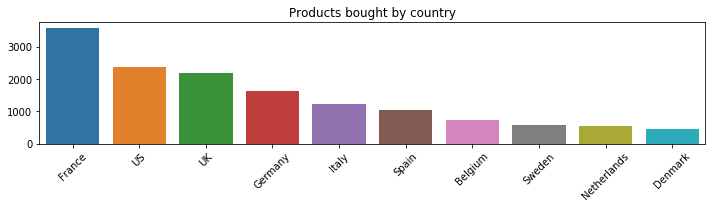

In [23]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=buying_top10['country'],y=buying_top10[('productsBought', 'sum')])
ax.set_title('Products bought by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [24]:
# Verification Buying
#data.groupby('country')[['productsBought','socialProductsLiked','productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).T

### 1.2. Feature Engineering

In [25]:
# Define countries as 'Other', if % of users is less then 1%
users_perc_lim = 1
other_countries = countries[countries['users_%_total']<users_perc_lim].index.tolist()
print(f'Other countries: {len(other_countries)}')
#print(other_countries)
data['country_short_list']=data['country'].apply(lambda x: 'Other' if x in other_countries else x)
countries_list = data['country_short_list'].unique().tolist()
print(f'Countries short list: {countries_list}')

Other countries: 114
Countries short list: ['UK', 'Denmark', 'US', 'Germany', 'Swiss', 'France', 'Other', 'Sweden', 'Canada', 'Australia', 'Italy', 'Spain', 'Belgium', 'Netherlands']


In [26]:
# Change the boolean column type to integer
data[booleans_cols]=data[booleans_cols].astype(int)

# Save the initial data to use with results of clustering
data_origin = data.copy()

# Duplicate columns
data['language_c']=data['language']
# Convert categorical variable into dummy/indicator variables
cat_features =['language', 'gender', 'country_short_list']
data = pd.get_dummies(data, columns=cat_features)

# Rename columns
data.rename(columns={'language_c': 'language'}, inplace=True)

# Preview data
data.drop(columns=['identifierHash']).head()

# Check that 'hasAnyApp' is 'hasAndroidApp' or 'hasIosApp'
(data['hasAndroidApp']+data['hasIosApp']-data['hasAnyApp']).isnull().sum()

0

In [27]:
data.drop('identifierHash', axis=1).head()

,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US
0,UK,3,8,4,0,0,0.0,0,0,0,0,0,1,591,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Denmark,3,8,370,0,0,0.0,1,0,0,0,0,1,42,3205,en,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,US,3,8,1,0,0,0.0,0,0,0,0,0,1,32,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Germany,3,8,27,0,0,0.0,0,0,1,0,1,1,669,3205,de,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Swiss,3,8,0,0,0,0.0,9,0,1,1,0,1,463,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
# Save the preprocessed data to a csv file
file = '2. Prepared Data/classification_e-commerce_preprocessed_data.csv'
data.to_csv(file, index = False)
data.shape

(21639, 38)

## 2. Clustering

### Features 

In [29]:
data.columns

Index(['identifierHash', 'country', 'socialNbFollowers', 'socialNbFollows',
       'socialProductsLiked', 'productsListed', 'productsSold',
       'productsPassRate', 'productsWished', 'productsBought', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'language', 'language_de', 'language_en', 'language_es',
       'language_fr', 'language_it', 'gender_F', 'gender_M',
       'country_short_list_Australia', 'country_short_list_Belgium',
       'country_short_list_Canada', 'country_short_list_Denmark',
       'country_short_list_France', 'country_short_list_Germany',
       'country_short_list_Italy', 'country_short_list_Netherlands',
       'country_short_list_Other', 'country_short_list_Spain',
       'country_short_list_Sweden', 'country_short_list_Swiss',
       'country_short_list_UK', 'country_short_list_US'],
      dtype='object')

In [30]:
features = ['productsListed', 'productsSold', 'productsBought', 'productsPassRate',
            'productsWished','socialProductsLiked','socialNbFollowers','socialNbFollows',
            'daysSinceLastLogin',
            'hasAnyApp','hasProfilePicture']
            #'language_de', 'language_en', 'language_es', 'language_fr', 'language_it']


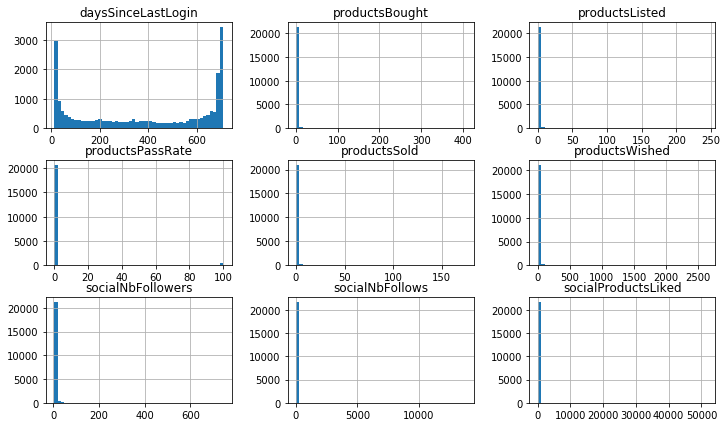

In [31]:
data_num = data[numeric_cols].drop(['identifierHash', 'seniority'], axis=1)
data_num.hist(figsize=(12,7), bins =50)
plt.show()

In [32]:
data_origin = data.copy()
transform_columns = ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed','productsSold', 'productsPassRate', 'productsWished', 'productsBought']

for column in transform_columns:
    data[column] = data[column].apply(lambda x: x**(1/2))

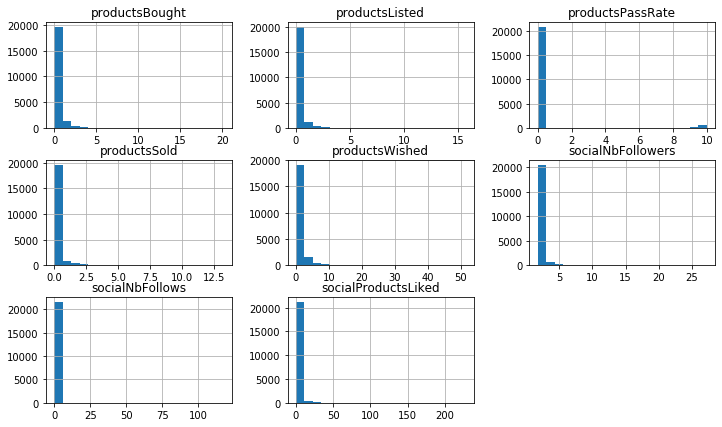

In [33]:
data_num = data[numeric_cols].drop(['identifierHash', 'seniority'], axis=1)
data[transform_columns].hist(figsize=(12,7), bins =20)
plt.show()

In [34]:
data.shape

(21639, 38)

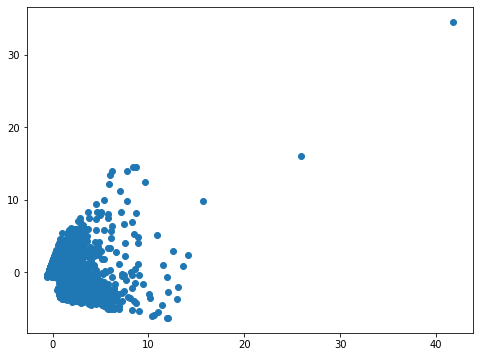

In [35]:
# Set up the data
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl[features])

df_scl['x']=df_pca[:,0]
df_scl['y']=df_pca[:,1]

plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()  

In [36]:
# Pick out the most significant outliers
outliers = df_scl[df_scl['x']>15]
data.loc[outliers.index]

,identifierHash,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US
8197,2119852871524485845,France,18.788294,90.928543,74.799733,2.236068,3.872983,8.124038,29.580399,0.0,1,0,1,0,31,3198,fr,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10975,3718185418791028367,Italy,27.276363,117.320075,227.312560,0.000000,10.198039,9.219544,42.918527,0.0,1,0,1,0,14,3195,it,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
17558,3275083886092943154,Sweden,11.180340,22.360680,83.928541,10.816654,8.185353,9.486833,25.768197,0.0,0,0,0,0,16,2855,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [37]:
# Drop the selected outliers
droped_outliers = data.loc[outliers.index]
data.drop(outliers.index, inplace=True)
print(data.shape)

(21636, 38)


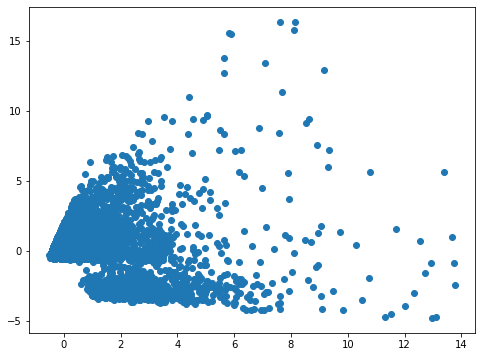

In [38]:
# Set up the data
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl[features])

plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()  

### Selecting of DBSCAN eps parameter

In [39]:
# DBSCAN
# Set up the data
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

X = df_scl[features]

print('DBSCAN:')
for e in [4, 4.5, 5, 5.5, 6, 6.5]:
    # The number of samples (or total weight)
    min_smpl = 5
    # Instantiate a DBSCAN Model, fit the model
    dbscan = DBSCAN(eps=e, min_samples = min_smpl, metric='manhattan').fit(X)
    # Store labels formed by the DBSCAN
    labels = dbscan.labels_

    # Number of clusters
    n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)
    # Silhouette Score
    sil_coeff= silhouette_score(X, labels, metric='manhattan')
    print(f'eps={e}, min_samples={min_smpl}, n_clusters_={n_clusters_}, Silhoette Coefficient: {sil_coeff}')
    print(pd.DataFrame(labels,columns=['labels'])['labels'].value_counts())

DBSCAN:
eps=4, min_samples=5, n_clusters_=3, Silhoette Coefficient: 0.7141281686477347
 0    20398
-1      690
 1      544
 2        4
Name: labels, dtype: int64
eps=4.5, min_samples=5, n_clusters_=2, Silhoette Coefficient: 0.732283838295103
 0    20474
 1      611
-1      551
Name: labels, dtype: int64
eps=5, min_samples=5, n_clusters_=2, Silhoette Coefficient: 0.7391393409116916
 0    20529
 1      669
-1      438
Name: labels, dtype: int64
eps=5.5, min_samples=5, n_clusters_=2, Silhoette Coefficient: 0.7435534738716996
 0    20557
 1      710
-1      369
Name: labels, dtype: int64
eps=6, min_samples=5, n_clusters_=2, Silhoette Coefficient: 0.8207980368675414
 0    21340
-1      291
 1        5
Name: labels, dtype: int64
eps=6.5, min_samples=5, n_clusters_=1, Silhoette Coefficient: 0.8377668386618166
 0    21384
-1      252
Name: labels, dtype: int64


 Because in case  
 eps = 6, min_samples = 5, n_clusters_ = 2, Silhoette Coefficient: 0.8207980368675414  
 only there are 5 poits into second cluster,   
 eps = 5.5, min_samples = 5, n_clusters_ = 2, Silhoette Coefficient: 0.7435534738716996  
 is considered as the best option.

In [40]:
# Create variables for selected DBSCAN parameters
best_eps = 5.5
best_min_samples = 5
best_n_clusters = 2

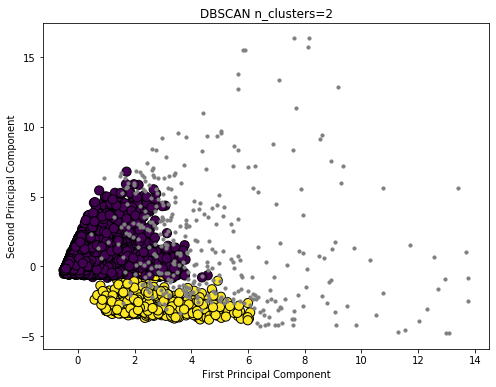

DBSCAN:
n_clusters=2, Silhoette Coefficient: 0.7435534738716996
 0    20557
 1      710
-1      369
Name: dbscan_labels, dtype: int64


In [41]:
# DBSCAN
# Set up the data
df = data[features].copy()
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

X = df_scl[features]

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(X)

# Instantiate a DBSCAN Model, fit the model
dbscan = DBSCAN(eps=best_eps, min_samples = best_min_samples, metric='manhattan').fit(X)
# Store labels formed by the DBSCAN
labels = dbscan.labels_

# Save clasters to the DataFrames
df['dbscan_labels'] = labels

# Save the PCA components to the DataFrame
df['x']=df_pca[:,0]
df['y']=df_pca[:,1]

# Number of clusters
n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)

# Plot the result
plt.figure(figsize=(8,6))

# Plot the clustered data
clust = df['dbscan_labels']!=-1
data_cl = df.loc[clust]
plt.scatter(data_cl['x'], data_cl['y'], c=data_cl['dbscan_labels'], edgecolors='k', s=84)

# Plot the noise
outl = df['dbscan_labels']==-1
data_outl = df.loc[outl]
plt.scatter(data_outl['x'], data_outl['y'], c='grey', edgecolors='grey', s=10)

plt.title(f'DBSCAN n_clusters={n_clusters_}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('DBSCAN:')
# Silhouette Score
sil_coeff= silhouette_score(X, labels, metric='manhattan')
print(f'n_clusters={n_clusters_}, Silhoette Coefficient: {sil_coeff}')
print(df['dbscan_labels'].value_counts())

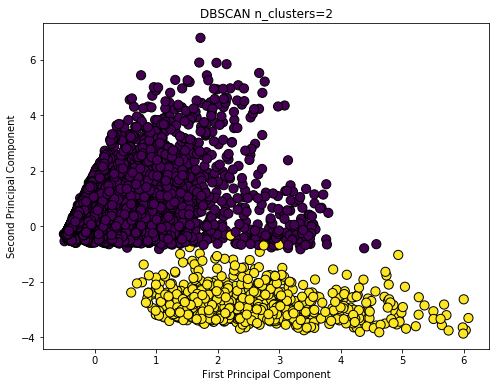

DBSCAN:
n_clusters=2, Silhoette Coefficient: 0.7435534738716996
 0    20557
 1      710
-1      369
Name: dbscan_labels, dtype: int64


In [42]:
# Plot the result: clustered data
plt.figure(figsize=(8,6))

plt.scatter(data_cl['x'], data_cl['y'], c=data_cl['dbscan_labels'], edgecolors='k', s=84)

plt.title(f'DBSCAN n_clusters={n_clusters_}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('DBSCAN:')
# Silhouette Score
sil_coeff= silhouette_score(X, labels, metric='manhattan')
print(f'n_clusters={n_clusters_}, Silhoette Coefficient: {sil_coeff}')
print(df['dbscan_labels'].value_counts())

### Clustered data

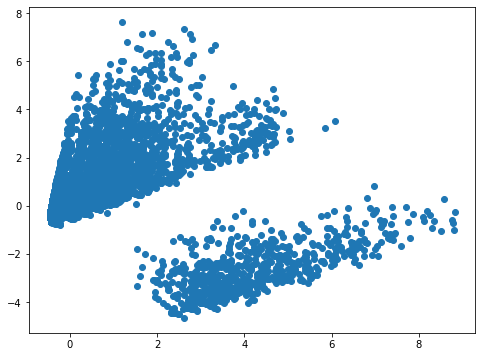

In [43]:
# Set up the clustered data
df_cl = data.loc[data_cl.index][features].copy()
#df_cl = data_cl[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_cl[features] = RobustScaler().fit_transform(df_cl)

C = df_cl[features]

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca_cl = pca.fit_transform(C)

plt.figure(figsize=(8,6))
plt.scatter(df_pca_cl[:,0],df_pca_cl[:,1])
plt.show() 

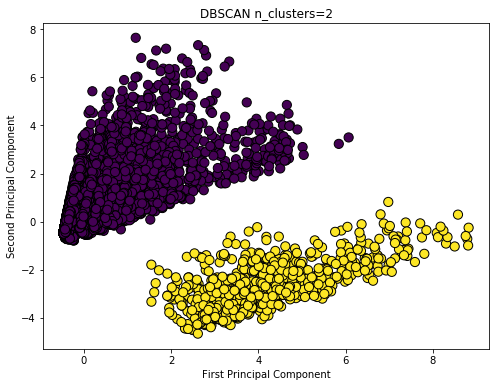

DBSCAN:
n_clusters=2, Silhoette Coefficient: 0.7604039182035055
0    20557
1      710
Name: dbscan_labels, dtype: int64


In [44]:
# Instantiate a DBSCAN Model, fit the model
dbscan = DBSCAN(eps=best_eps, min_samples = best_min_samples, metric='manhattan').fit(C)
# Store labels formed by the DBSCAN
labels = dbscan.labels_

# Save clasters to the DataFrames
df_cl['dbscan_labels'] = labels

# Save the PCA components to the DataFrame
df_cl['x']=df_pca_cl[:,0]
df_cl['y']=df_pca_cl[:,1]

# Number of clusters
n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)

# Plot the result
plt.figure(figsize=(8,6))

# Plot the clustered data
clust = df_cl['dbscan_labels']!=-1
data_cl_2 = df_cl.loc[clust]
plt.scatter(data_cl_2['x'], data_cl_2['y'], c=data_cl_2['dbscan_labels'], edgecolors='k', s=84)

# Plot the noise
outl = df_cl['dbscan_labels']==-1
data_outl_2 = df_cl.loc[outl]
plt.scatter(data_outl_2['x'], data_outl_2['y'], c='grey', edgecolors='grey', s=10)

plt.title(f'DBSCAN n_clusters={n_clusters_}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('DBSCAN:')
# Silhouette Score
sil_coeff= silhouette_score(C, labels, metric='manhattan')
print(f'n_clusters={n_clusters_}, Silhoette Coefficient: {sil_coeff}')
print(df_cl['dbscan_labels'].value_counts())

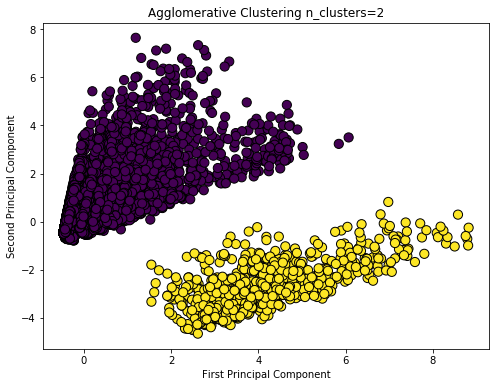

Agglomerative Clustering:
n_clusters=2, Silhouette Coefficient: 0.7604039182035055
0    20557
1      710
Name: aggl_labels, dtype: int64


In [45]:
# Agglomerative Clustering
aggl = AgglomerativeClustering(n_clusters=best_n_clusters, affinity='manhattan', linkage='average').fit(C)

labels = aggl.labels_
n_clusters = aggl.n_clusters_
df_cl['aggl_labels'] = labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_cl['x'], df_cl['y'], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clustering n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Agglomerative Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(C, labels, metric='manhattan')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
print(df_cl['aggl_labels'].value_counts())

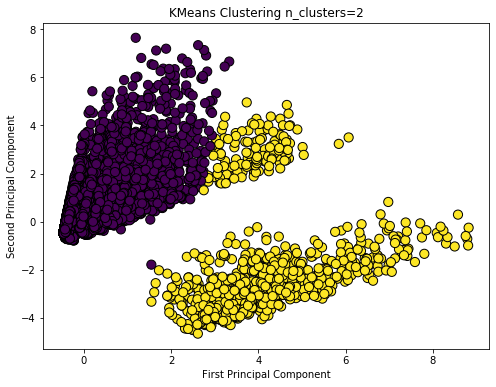

KMeans Clustering:
n_clusters=2, Silhouette Coefficient: 0.7525041239287844
0    20413
1      854
Name: kmeans_labels, dtype: int64


In [46]:
# KMeans Clustering
km = cluster.KMeans(n_clusters=best_n_clusters, max_iter=500, random_state=None).fit(C)
labels = km.labels_
df_cl['kmeans_labels'] = labels
# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_cl['x'], df_cl['y'], c=labels, edgecolors='k', s=84)

plt.title(f'KMeans Clustering n_clusters={best_n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('KMeans Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(C, labels, metric='euclidean')
print(f'n_clusters={best_n_clusters}, Silhouette Coefficient: {sil_coeff}')
print(df_cl['kmeans_labels'].value_counts())

### The Data Marked as Noise by DBSCAN

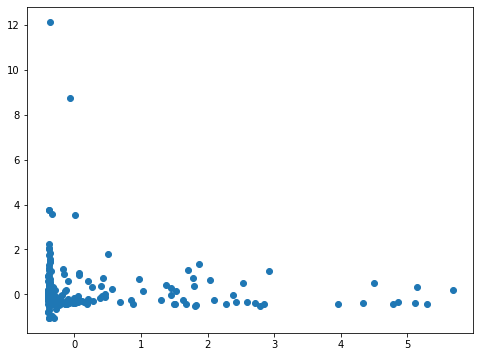

In [47]:
# Copy the not clustered data
df_n = data.loc[data_outl.index][features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_n[features] = RobustScaler().fit_transform(df_n)

N = df_n[features]

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca_n = pca.fit_transform(N)

plt.figure(figsize=(8,6))
plt.scatter(df_pca_n[:,0],df_pca_n[:,1])
plt.show()

In [48]:
print('KMeans Clustering:')
# Silhouette method
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, max_iter=500, random_state=None).fit(N)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(N, labels, metric='euclidean')
    print(f'n_clusters={n_cluster}, Silhouette Coefficient: {sil_coeff}')  

KMeans Clustering:
n_clusters=2, Silhouette Coefficient: 0.7784691027549498
n_clusters=3, Silhouette Coefficient: 0.7371748150749693
n_clusters=4, Silhouette Coefficient: 0.7464429056362512
n_clusters=5, Silhouette Coefficient: 0.46458992973799385
n_clusters=6, Silhouette Coefficient: 0.4361117731600435
n_clusters=7, Silhouette Coefficient: 0.28393721788460496
n_clusters=8, Silhouette Coefficient: 0.27989754174670833
n_clusters=9, Silhouette Coefficient: 0.21545920378422598
n_clusters=10, Silhouette Coefficient: 0.2149068211511159


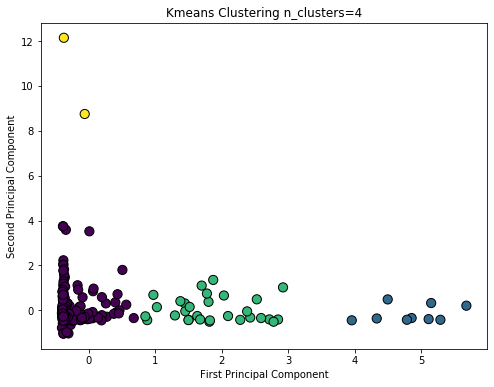

Kmeans:
n_clusters=4, Silhouette Coefficient: 0.7464429056362512


In [49]:
# KMeans with 4 clusters 
km = cluster.KMeans(n_clusters=4, max_iter=500, random_state=None)
labels = km.fit_predict(N)
n_clusters = km.n_clusters

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca_n[:,0],df_pca_n[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Kmeans Clustering n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Kmeans:')
# Silhouette Score
sil_coeff = silhouette_score(N, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')

In [50]:
print('Agglomerative Clustering:')
# Silhouette method
for n_cluster in range(2, 11):
    aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='average').fit(N)
    labels = aggl.labels_
    sil_coeff = silhouette_score(N, labels, metric='euclidean')
    print(f'n_clusters={n_cluster}, Silhouette Coefficient: {sil_coeff}') 

Agglomerative Clustering:
n_clusters=2, Silhouette Coefficient: 0.8179777683975754
n_clusters=3, Silhouette Coefficient: 0.7670732605528854
n_clusters=4, Silhouette Coefficient: 0.7529454485349707
n_clusters=5, Silhouette Coefficient: 0.7474164409696525
n_clusters=6, Silhouette Coefficient: 0.6119416998912486
n_clusters=7, Silhouette Coefficient: 0.595875810379663
n_clusters=8, Silhouette Coefficient: 0.48154932239530357
n_clusters=9, Silhouette Coefficient: 0.47577718141365594
n_clusters=10, Silhouette Coefficient: 0.4769469804589501


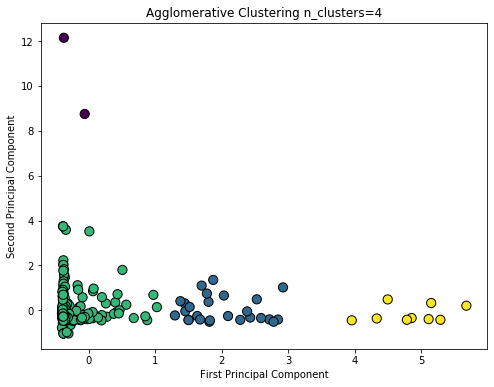

Agglomerative Clustering:
n_clusters=4, Silhouette Coefficient: 0.7529454485349707


In [51]:
# Agglomerative Clustering
aggl = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average').fit(N)
labels = aggl.labels_
n_clusters = aggl.n_clusters_

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca_n[:,0],df_pca_n[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clustering n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Agglomerative Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(N, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')

In [52]:
print('DBSCAN:')
for e in [10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14]:
    # The number of samples (or total weight)
    min_smpl = 6
    # Instantiate a DBSCAN Model, fit the model
    dbscan = DBSCAN(eps=e, min_samples = min_smpl, metric='manhattan').fit(N)
    # Store labels formed by the DBSCAN
    labels = dbscan.labels_

    # Number of clusters
    n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)
    # Silhouette Score
    sil_coeff= silhouette_score(N, labels, metric='manhattan')
    print(f'eps={e}, min_smpl={min_smpl}, n_clusters={n_clusters_}, Silhoette Coefficient: {sil_coeff}')
    #print(df['labels'].value_counts())

DBSCAN:
eps=10, min_smpl=6, n_clusters=2, Silhoette Coefficient: 0.6078345782683023
eps=10.5, min_smpl=6, n_clusters=2, Silhoette Coefficient: 0.6397172657214916
eps=11, min_smpl=6, n_clusters=2, Silhoette Coefficient: 0.6397172657214916
eps=11.5, min_smpl=6, n_clusters=2, Silhoette Coefficient: 0.6827388786646462
eps=12, min_smpl=6, n_clusters=2, Silhoette Coefficient: 0.6827388786646462
eps=12.5, min_smpl=6, n_clusters=2, Silhoette Coefficient: 0.6827388786646462
eps=13, min_smpl=6, n_clusters=1, Silhoette Coefficient: 0.6829536725597979
eps=13.5, min_smpl=6, n_clusters=1, Silhoette Coefficient: 0.6829536725597979
eps=14, min_smpl=6, n_clusters=1, Silhoette Coefficient: 0.6829536725597979


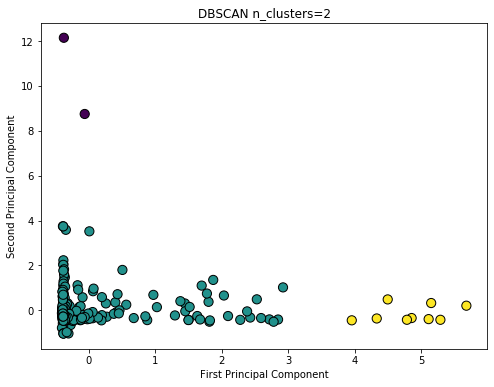

DBSCAN:
Estimated number of clusters: 2 Silhoette Coefficient: 0.6827388786646462


In [53]:
# Instantiate a DBSCAN Model, fit the model
dbscan = DBSCAN(eps=12.5, min_samples = 6, metric='manhattan').fit(N)
# Store labels formed by the DBSCAN
labels = dbscan.labels_
# Number of clusters
n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca_n[:,0],df_pca_n[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'DBSCAN n_clusters={n_clusters_}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('DBSCAN:')
# Silhouette Score
sil_coeff= silhouette_score(N, labels, metric='manhattan')
print(f'Estimated number of clusters: {n_clusters_} Silhoette Coefficient: {sil_coeff}')

### Final model
<b>Step 1:</b>  Split up 2 clusters and noise.   
<i>DBSCAN(eps=5.5, min_samples = 5, metric='manhattan')</i>   
Outcome:
Clusters: 2, Silhoette Coefficient: 0.7435534738716996

<b>Step 2:</b>  Cluster customers with not very common pattern of behaviour.        
<i>Agglomerative Clustering(n_clusters=4, affinity='euclidean', linkage='average')</i>  
Outcome:
Clusters=4, Silhouette Coefficient: 0.7529454485349707    

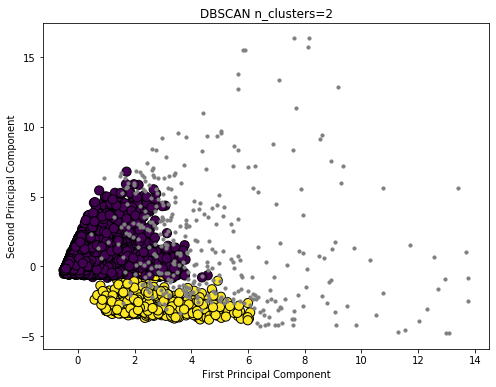

DBSCAN:
Estimated number of clusters: 2 Silhoette Coefficient: 0.7435534738716996
 0    20557
 1      710
-1      369
Name: dbscan_labels, dtype: int64


In [54]:
# DBSCAN
# Set up the data
df = data[features].copy()
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

X = df_scl[features]

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(X)

# Instantiate a DBSCAN Model, fit the model
dbscan = DBSCAN(eps=best_eps, min_samples = best_min_samples, metric='manhattan').fit(X)
# Store labels formed by the DBSCAN
labels = dbscan.labels_

# Save clasters to the DataFrames
df['dbscan_labels'] = labels

# Save the PCA components to the DataFrame
df['x']=df_pca[:,0]
df['y']=df_pca[:,1]

# Number of clusters
n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)

# Plot the result
plt.figure(figsize=(8,6))

# Plot the clustered data
clust = df['dbscan_labels']!=-1
data_cl = df.loc[clust]
plt.scatter(data_cl['x'], data_cl['y'], c=data_cl['dbscan_labels'], edgecolors='k', s=84)

# Plot the noise
outl = df['dbscan_labels']==-1
data_outl = df.loc[outl]
plt.scatter(data_outl['x'], data_outl['y'], c='grey', edgecolors='grey', s=10)

plt.title(f'DBSCAN n_clusters={n_clusters_}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('DBSCAN:')
# Silhouette Score
sil_coeff= silhouette_score(X, labels, metric='manhattan')
print(f'Estimated number of clusters: {n_clusters_} Silhoette Coefficient: {sil_coeff}')
print(df['dbscan_labels'].value_counts())

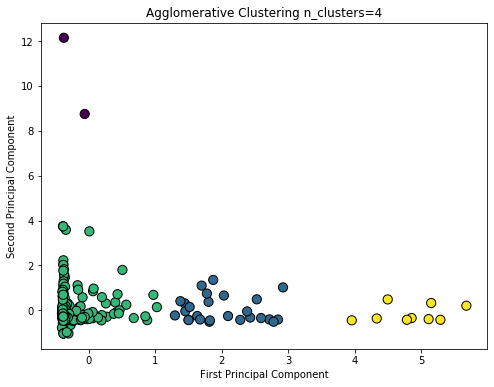

Agglomerative Clustering:
For n_clusters=4, The Silhouette Coefficient: 0.7529454485349707


In [55]:
# Agglomerative Clustering

# Copy the not clustered data
df_n = data.loc[data_outl.index][features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_n[features] = RobustScaler().fit_transform(df_n)

N = df_n[features]

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca_n = pca.fit_transform(N)

# Agglomerative Clustering
aggl = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average').fit(N)
labels = aggl.labels_
n_clusters = aggl.n_clusters_

df_n['aggl_labels']=labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca_n[:,0],df_pca_n[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clustering n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Agglomerative Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(N, labels, metric='euclidean')
print(f'For n_clusters={n_clusters}, The Silhouette Coefficient: {sil_coeff}')

In [56]:
result = data_origin.merge(df_n['aggl_labels'], how='outer', left_index=True, right_index=True)
result =  result.merge(df['dbscan_labels'], how='outer', left_index=True, right_index=True)
#result = pd.concat([result, droped_outliers])
print(result.shape)

(21639, 40)


In [57]:
result.tail()

,identifierHash,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US,aggl_labels,dbscan_labels
21634,4508710134224075356,France,3,8,1,0,0,0.0,4,0,0,0,0,1,477,3204,fr,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,0.0
21635,4715935376764926056,Germany,3,8,10,0,0,0.0,0,0,1,0,1,1,15,3204,en,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,0.0
21636,839748404208280164,France,3,8,5,0,0,0.0,2,5,0,0,0,1,192,3204,fr,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,0.0
21637,7257878909040060228,Spain,3,8,31,0,0,0.0,0,0,0,0,0,1,13,3204,es,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,0.0
21638,3164321379397826945,US,3,8,6,0,0,0.0,0,0,0,0,0,1,655,3204,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0.0


In [58]:
# Transform labels of two models to get the ultimate set of clusters' labels

# Change DBSCAN labels by adding 1
result['dbscan_labels']=result['dbscan_labels'].apply(lambda x: x+1)
result['dbscan_labels'].replace(np.nan, 0, inplace=True)
# Change Agglomerative Clustering labels by adding 3
result['aggl_labels']=result['aggl_labels'].apply(lambda x: x+3)
result['aggl_labels'].replace(np.nan, 0, inplace=True)
# Sum labels of two models
result['labels']=result['dbscan_labels']+result['aggl_labels']
result['labels'].value_counts()

1.0    20557
2.0      710
5.0      332
4.0       26
6.0        9
0.0        3
3.0        2
Name: labels, dtype: int64

In [59]:
# Save the clustered data to a csv file
file = '5. Insights/classification_e-commerce_clusters.csv'
result.to_csv(file, index = False)